## Multivariate Imputation of Chained Equations (MICE)

This is a multiple-rounds framework to impute missing values

- In the 1st round, a missing variable is modelling using other variables, which themselves may contain NA as well.

- Usually, 10 imputation cycles are enough to find stable parameters.

- Different models should be used, depends on the nature of our variables:

    - Binary variables should be modelled with classification algorithms
    - Continous vars - regression
    - Discrete vars - Poisson, etc.

#### Assumptions

- Data is **MAR**

- The NA in the variables can be modelled by the other vars in the dataset, and does not depend on external source.

#### Considerations

- Circular dependence can occur: same observations show NS on several vars -> the vars may be correlated



In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

TEST_SIZE = 0.3
RANDOM_STATE = 44
MAX_ITER = 10 # number of cycles, usually 10 is enough for a stable parameters

In [34]:
# load data
cols_to_use = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A16']
data = pd.read_csv("../data/creditApprovalUCI.csv", usecols=cols_to_use)
data.head()

,A2,A3,A8,A11,A14,A15,A16
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,NaN,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


In [35]:
# split data to train, test sets before "learning" to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['A16'], axis=1),
    data['A16'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [36]:
# proportion of missing data 
X_train.isna().mean()

A2     0.018634
A3     0.128364
A8     0.128364
A11    0.000000
A14    0.016563
A15    0.000000
dtype: float64

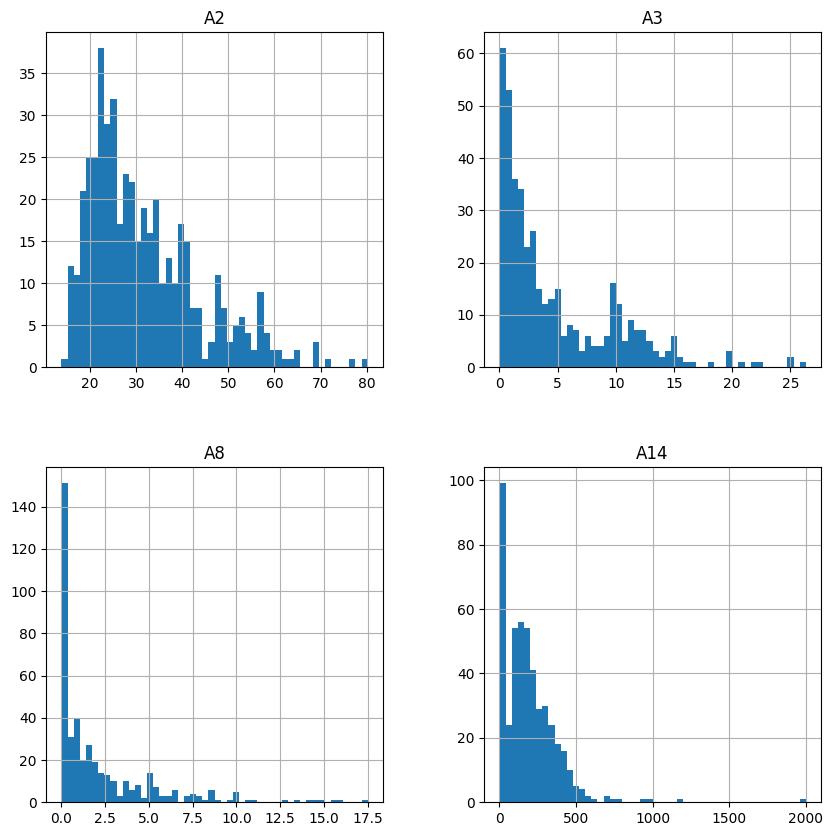

In [37]:
# distribution of vars with missing data
na_vars = [var for var in X_train.columns if X_train[var].isna().sum() > 0]
X_train[na_vars].hist(bins=50, figsize=(10,10))
plt.show()

Most vars with missing data are continous, we can use regression model for MICE

In [38]:
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',# start with mean for round 1 with missing values of other vars
    max_iter=MAX_ITER,
    imputation_order="ascending",
    n_nearest_features=None,
    skip_complete=True,
    random_state=RANDOM_STATE
)

In [39]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [40]:
imputer.fit(X_train)

,estimator,BayesianRidge()
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,True
,min_value,-inf


In [41]:
train_imputed = imputer.transform(X_train)
test_imputed = imputer.transform(X_test)

train_imputed = pd.DataFrame(train_imputed, columns=X_train.columns)
test_imputed = pd.DataFrame(test_imputed, columns=X_test.columns)

print(train_imputed.head(5))
print(test_imputed.head(5))

      A2         A3        A8   A11    A14     A15
0  30.75   1.585000  0.585000   0.0    0.0     0.0
1  25.08   1.710000  1.665000   1.0  395.0    20.0
2  22.17   3.909734  1.121182   0.0  160.0    10.0
3  25.00   0.875000  1.040000   0.0  160.0  5860.0
4  56.50  16.000000  0.000000  15.0    0.0   247.0
      A2        A3        A8  A11    A14   A15
0  51.83  5.336552  3.964956  0.0  180.0   4.0
1  18.58  4.130414  0.834581  0.0   80.0  42.0
2  40.92  0.500000  0.500000  0.0  130.0   0.0
3  31.83  2.500000  7.500000  0.0  523.0   0.0
4  18.00  0.165000  0.210000  0.0  200.0  40.0


In [42]:
print(X_train[X_train['A3'].isna()]['A3'].head(5))
print(train_imputed[X_train['A3'].isna()]['A3'].head(5))

2    NaN
12   NaN
14   NaN
21   NaN
22   NaN
Name: A3, dtype: float64
2     3.909734
12    6.944327
14    3.437231
21    4.451648
22    3.772984
Name: A3, dtype: float64


Let's try other models for MICE

In [43]:
imputer_bayed = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE
)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5),
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE
)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(
        max_features='sqrt', 
        random_state=RANDOM_STATE),
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE
)

imputer_missForrest = IterativeImputer(
    estimator=ExtraTreesRegressor(
        n_estimators=10, 
        random_state=RANDOM_STATE),
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE
)

In [ ]:
imputer_bayed.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForrest.fit(X_train)

In [45]:
train_imputed_bayes = imputer_bayed.transform(X_train)
train_imputed_knn = imputer_knn.transform(X_train)
train_imputed_nonLin = imputer_nonLin.transform(X_train)
train_imputed_missForest = imputer_missForrest.transform(X_train)

In [46]:
train_imputed_bayes = pd.DataFrame(train_imputed_bayes, columns=X_train.columns)
train_imputed_knn = pd.DataFrame(train_imputed_knn, columns=X_train.columns)
train_imputed_nonLin = pd.DataFrame(train_imputed_nonLin, columns=X_train.columns)
train_imputed_missForest = pd.DataFrame(train_imputed_missForest, columns=X_train.columns)


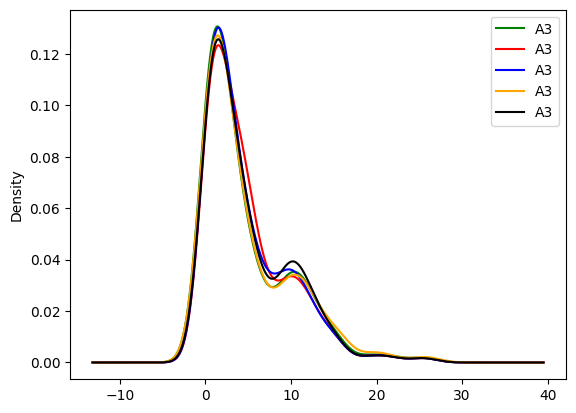

In [47]:
fig, ax = plt.subplots()

X_train['A3'].plot(kind="kde", ax=ax, color="green")
train_imputed_bayes['A3'].plot(kind="kde", ax=ax, color="red")
train_imputed_knn['A3'].plot(kind="kde", ax=ax, color="blue")
train_imputed_nonLin['A3'].plot(kind="kde", ax=ax, color="orange")
train_imputed_missForest['A3'].plot(kind="kde", ax=ax, color="black")

lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.legend()
plt.show()